# importing and loading data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.iotools import read_tmy3
from pvlib.pvsystem import PVSystem, FixedMount, Array
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.location import Location
import datetime
import pytz
import os
import itertools
import inspect
import calendar
import h5py
from pvlib import pvsystem, location, modelchain, iotools,tools
import pathlib
from dataclasses import dataclass
from pvlib import tracking
from netCDF4 import num2date
from requests.exceptions import HTTPError
from xml.etree.ElementTree import ParseError
from pvlib.irradiance import campbell_norman, get_extra_radiation, disc, louche, erbs_driesse, ghi_from_poa_driesse_2023
from pvlib.irradiance import _liujordan, get_total_irradiance
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import warnings
from pvlib._deprecation import deprecated
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

In [2]:
def root_mean_square_deviation(y_pred, y_meas):
    y_pred = np.array(y_pred)
    y_meas = np.array(y_meas)
    rmse = np.sqrt(np.mean((y_pred - y_meas) ** 2))
    return rmse

def mean_bias_deviation(y_pred, y_meas):
    y_pred = np.array(y_pred)
    y_meas = np.array(y_meas)
    mbd = np.mean(y_pred - y_meas)
    return mbd

def r_squared(y_pred, y_meas):
    y_pred = np.array(y_pred)
    y_meas = np.array(y_meas)
    ss_res = np.sum((y_meas - y_pred) ** 2)
    ss_tot = np.sum((y_meas - np.mean(y_meas)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2


In [3]:
#BSRN QC
#data_path ='AB_2018.csv'
data_path ='STEL_2015_201620182019C_GHI.csv'
bsrn_features = pd.read_csv(data_path, index_col=[0], parse_dates=[0])
#bsrn_features.index = bsrn_features.index.tz_localize('Africa/Johannesburg')  # Make the index timezone aware
original_entries = bsrn_features.shape[0]
bsrn_features.head(2)  # Print the first two lines of the DataFrame

,k_d,k_t,zenith,airmass,ast
DATE,,,,,
2015-01-01 07:31:00+02:00,333.224,512.188103,68.777384,2.746518,0.361993
2015-01-01 07:32:00+02:00,338.062,516.803982,68.576732,2.722327,0.365255


In [4]:
#ghi = (1098.0 * cos_solar_zenith  * np.exp(-0.059/cos_solar_zenith))

In [5]:
bsrn_features = bsrn_features.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()

In [6]:
top_features =['k_d','k_t','zenith','airmass','ast']

In [7]:
#k_d=GHIc #k_t=GHI_TOA #ast=cosine_zenith

In [8]:
bsrn_features = bsrn_features.reset_index(drop=True)

In [9]:
bsrn_features.head()

,k_d,k_t,zenith,airmass,ast
0,333.224,512.188103,68.777384,2.746518,0.361993
1,338.062,516.803982,68.576732,2.722327,0.365255
2,342.779,521.416101,68.375968,2.698573,0.368515
3,347.496,526.024371,68.175092,2.675247,0.371771
4,351.971,530.628699,67.974106,2.652336,0.375026


In [10]:
bsrn_features.describe().T

,count,mean,std,min,25%,50%,75%,max
k_d,305600.0,685.743551,229.667676,86.705500,500.537000,676.562000,882.515250,1151.480000
k_t,305600.0,908.255284,273.075446,120.269094,691.289352,895.355890,1143.722047,1390.472595
zenith,305600.0,46.819204,15.957631,10.492958,34.732846,49.395205,59.417029,84.838471
airmass,305600.0,1.676899,0.593729,1.016755,1.216093,1.534572,1.960645,10.043069
ast,305600.0,0.657162,0.189801,0.089964,0.508786,0.650838,0.821818,0.983277


In [11]:
#for key,group in bsrn_features.groupby('Station'):
    #print(key,len(group.index),len(group.index)*5)

In [12]:
features = [col for col in bsrn_features.columns if not col == 'k_d']
latex_predictors = pd.Series(index=features,data=['k$_t$','$\\theta_z$','AM','AST'])
latex_predictors['k_d'] = 'k$_d$'
latex_predictors

k_t             k$_t$
zenith     $\theta_z$
airmass            AM
ast               AST
k_d             k$_d$
dtype: object

# data splitting and analysis

In [13]:
bsrn_features = bsrn_features[top_features]
X = bsrn_features.drop('k_d', axis=1)
y = bsrn_features['k_d']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Correlation matrix

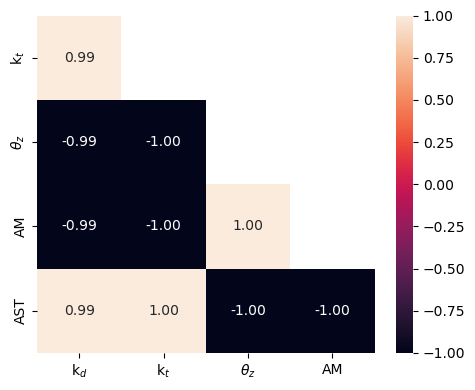

In [14]:
corr = bsrn_features[top_features].corr(method='spearman')
plt.figure(figsize=(5,4))
ax = sns.heatmap(corr.iloc[1:,:-1],annot=True,mask=np.tri(len(top_features)-1,k=0)-1,square=True,fmt='.2f')
ax.set_yticklabels([latex_predictors[pred.get_text()] for pred in ax.get_yticklabels()])
ax.set_xticklabels([latex_predictors[pred.get_text()] for pred in ax.get_xticklabels()])
ax.figure.tight_layout()
ax.figure.savefig('selected_features_spearman_heatmap.png',dpi=300,bbox_inches='tight')

# Decision tree visual

In [15]:
from sklearn.tree import *
tree = DecisionTreeRegressor(random_state=0,max_leaf_nodes=6)
tree.fit(X_train,y_train)

DecisionTreeRegressor(max_leaf_nodes=6, random_state=0)

In [16]:
tree_config = export_graphviz(tree,out_file=None)

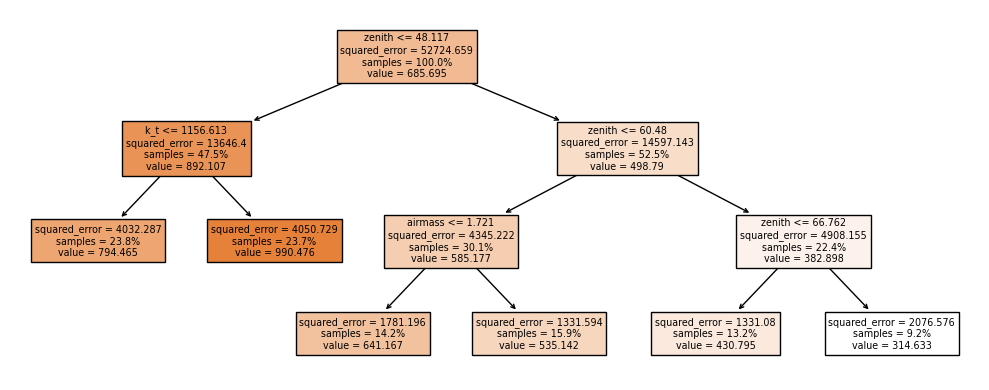

In [17]:
plt.figure(figsize=(10,4))
ax = plot_tree(tree,feature_names=bsrn_features.columns[1:],filled=True,proportion=True)
plt.tight_layout()

# Plot-based with curve_fit

In [18]:
X_train.columns

Index(['k_t', 'zenith', 'airmass', 'ast'], dtype='object')

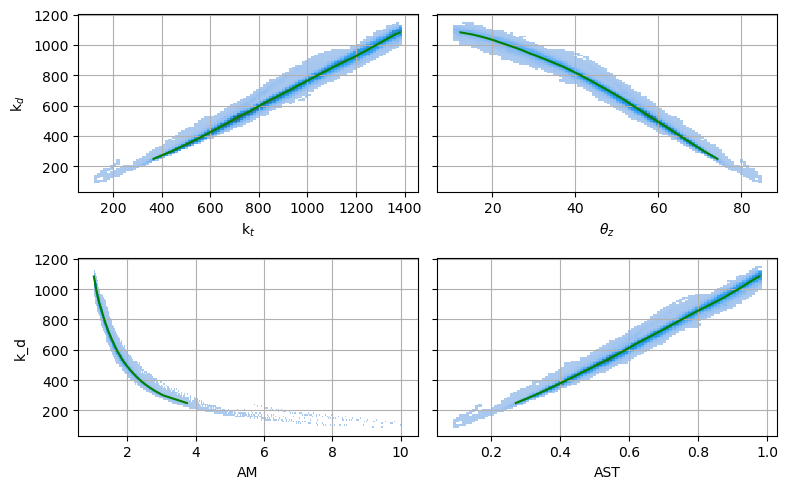

In [19]:
fig,axes = plt.subplots(2,2,figsize=(8,5),sharey=True,sharex=False)
axes = np.concatenate(axes)
for i,pred in enumerate(X_train.columns):
    ax = axes[i]
    ax.grid()
    sns.histplot(bsrn_features,x=pred,y='k_d',ax=ax)
    #ax.set_xlabel(latex_predictors[pred])
    pred_bins = pd.qcut(bsrn_features[pred],50)
    pred_means = bsrn_features[pred].groupby(pred_bins).mean()
    kd_means = bsrn_features['k_d'].groupby(pred_bins).mean()
    sns.lineplot(x=pred_means,y=kd_means,ax=ax,color='green')
    ax.set_xlabel(latex_predictors[pred])
axes[0].set_ylabel("k$_d$")
axes[3].set_ylabel("k$_d$")
fig.tight_layout()
#fig.savefig('predictor_kd_relationships.png',dpi=300,bbox_inches='tight')

In [20]:
#GHIC = (1098.0 * cos_solar_zenith  * np.exp(-0.059/cos_solar_zenith))

#GHIc(Mabasa/new) = (a * ghi_extra)  * np.exp(b*airmass )

0.8484949399212778,-0.07772721015582947
R^2: 0.98847


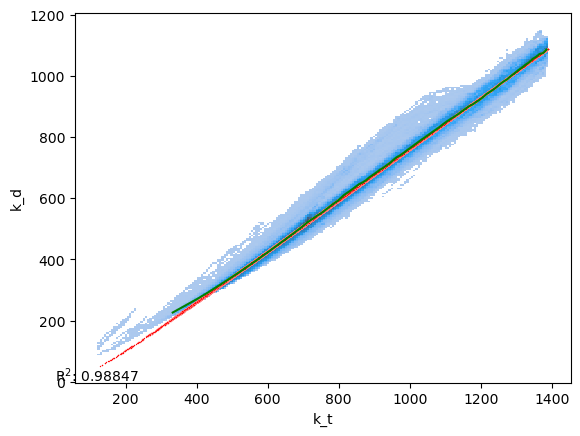

In [21]:
def kd_model_5g(X,a,b):
    [x1,x2] = X
    return  a*x1 * np.exp(b * x2)
    
pred = 'k_t'
preds = ['k_t','airmass']
fun = kd_model_5g
ax = sns.histplot(bsrn_features,x=pred,y='k_d',bins=200)
pred_bins = pd.qcut(bsrn_features[pred],99)
pred_means = bsrn_features[pred].groupby(pred_bins).mean()
kd_means = bsrn_features['k_d'].groupby(pred_bins).mean()
sns.lineplot(x=pred_means,y=kd_means,ax=ax,color='green')
X = [X_train[pred].values for pred in preds]
params,_ = curve_fit(fun,X,y_train,p0=[0,0],maxfev=10000)

fit = fun([X_test[pred].values for pred in preds],*params)
_ = sns.scatterplot(x=X_test[pred],y=fit,color='red',ax=ax,s=1)
print(",".join(params.astype(str)))
r2 = r_squared(fit,y_test)
ax.text(0,0.1,'R$^2$: %.5f' % r2)
print("R^2: %.5f" % r2)

In [22]:
ax.figure.savefig('SA.png',dpi=300,bbox_inches='tight')

In [23]:
RMSE = np.sqrt(np.mean((y_test - fit) ** 2))
MAE = np.mean(abs(fit - y_test))
MBE = np.mean(fit - y_test)
MBE,MAE,RMSE,r2

(-0.1646485931212797,
 17.705703083828755,
 24.68434159238247,
 0.9884679174711466)

In [24]:
pwd

'C:\\Users\\Brighton.Mabasa\\CLEARSKY MODEL DATA PREPARATION\\STEL\\STEL2\\3 CLEAR SKY DNI GHI CALIBRATION\\GHI'